# DACON FIFA 선수 이적료 예측 경진대회

<br>

##  개요
데이콘 주최 경진데회에서 주어진 데이터셋를 바탕으로 선수 이적료를 예측합니다.

<br>

## 데이터 소개
#### *1. FIFA_train.csv / FIFA_test.csv*
 - id : 선수 고유의 아이디 
 
 - name : 이름 
 
 - age : 나이  
 
 - continent : 선수들의 국적이 포함되어 있는 대륙입니다  
 
 - contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다  
 
 - position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등  
 
 - prefer_foot : 선수가 선호하는 발입니다. ex) 오른발  
 
 - reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수  
 
 - stat_overall : 선수의 현재 능력치 입니다.  
 
 - stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.  
 
 - stat_skill_moves : 선수의 개인기 능력치 입니다.  
 
 - value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다 . 
 

<br>

#### *2. submission.csv (제출 파일 형식)*
id : 선수 고유의 아이디
value : 예측된 선수 이적 시장 가격을 기입 

<br>

## 라이브러리 및 데이터 로드

In [561]:
# 라이브러리 로드

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import plotly

In [562]:
# 컬럼명 수가 길어질 때 컬럼들이 잘리는 것을 방지합니다.

pd.options.display.max_columns = None

In [563]:
# 학습 데이터셋을 불러옵니다.

train = pd.read_csv('FIFA_train.csv', index_col='id')
train.shape

(8932, 11)

In [564]:
# 테스트 데이터셋을 불러옵니다.

test = pd.read_csv('FIFA_test.csv', index_col='id')
test.shape

(3828, 10)

## 데이터 전처리

### 1. 인코딩  
머신러닝에 쓰이는 데이터는 정수형 자료만 사용 가능합니다.
문자열로 존재하는 데이터는 특정 인코딩 과정을 거쳐야 인식됩니다.

In [565]:
# 먼저 학습 데이터의 전반적인 분포를 살핍니다.

train.describe()

,age,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
mean,25.209136,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4.635515,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,16.000000,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,21.000000,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,25.000000,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,28.000000,1.000000,72.000000,76.000000,3.000000,2.600000e+06
max,40.000000,5.000000,94.000000,94.000000,5.000000,1.105000e+08


In [566]:
# 문자열과 정수형이 모두 존재합니다.
# 이름은 불필요하므로 제외합니다.

train = train.drop('name', axis='columns')
train.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
id,,,,,,,,,,
0,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
3,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
7,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
8,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
9,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [567]:
# 데이터의 정보를 확인합니다.
# 결측치는 없어, 관련 전처리는 생략합니다.

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8932 entries, 0 to 16948
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   continent         8932 non-null   object 
 2   contract_until    8932 non-null   object 
 3   position          8932 non-null   object 
 4   prefer_foot       8932 non-null   object 
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 767.6+ KB


In [568]:
# 테스트셋의 내용 또한 확인합니다. 
# 'name'을 마찬가지로 제거해줍니다.

test = test.drop('name', axis='columns')
test.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
id,,,,,,,,,
1,33,europe,2022,ST,right,5.0,94,94,5.0
2,26,south america,2022,ST,right,5.0,92,93,5.0
4,27,europe,2023,MF,right,4.0,91,92,4.0
5,27,europe,2020,ST,right,4.0,91,91,4.0
6,32,europe,2020,MF,right,4.0,91,91,4.0


In [569]:
test.describe()

,age,reputation,stat_overall,stat_potential,stat_skill_moves
count,3828.000000,3828.000000,3828.000000,3828.000000,3828.000000
mean,25.297806,1.143939,67.336991,72.107628,2.414838
std,4.628236,0.448465,6.908814,6.133428,0.781153
min,16.000000,1.000000,47.000000,52.000000,1.000000
25%,22.000000,1.000000,63.000000,68.000000,2.000000
50%,25.000000,1.000000,67.000000,72.000000,2.000000
75%,29.000000,1.000000,72.000000,76.000000,3.000000
max,42.000000,5.000000,94.000000,95.000000,5.000000


In [570]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3828 entries, 1 to 16943
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               3828 non-null   int64  
 1   continent         3828 non-null   object 
 2   contract_until    3828 non-null   object 
 3   position          3828 non-null   object 
 4   prefer_foot       3828 non-null   object 
 5   reputation        3828 non-null   float64
 6   stat_overall      3828 non-null   int64  
 7   stat_potential    3828 non-null   int64  
 8   stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(3), object(4)
memory usage: 299.1+ KB


In [571]:
# 계약 연도만 추출하여 정수형으로 반환하는 함수를 만듭니다.
# 계약연도가 보통 제일 끝에 있으므로 or 단독으로 쓰이므로 뒤에서 4번째부터 가지고 와줍니다.

def func(string:object) -> int:
    string = string[-4:] 
    return int(string)

train['contract_until'] = train['contract_until'].apply(func)
test['contract_until'] = test['contract_until'].apply(func)

In [572]:
train['continent'] = train['continent'].astype('category').cat.codes
train['position'] = train['position'].astype('category').cat.codes
train['prefer_foot'] = train['prefer_foot'].astype('category').cat.codes

In [573]:
test['continent'] = test['continent'].astype('category').cat.codes
test['position'] = test['position'].astype('category').cat.codes
test['prefer_foot'] = test['prefer_foot'].astype('category').cat.codes

In [574]:
# 문자형 변수들을 label 인코딩해줍니다.
# one-hot-encoding을 진행할 경우 컬럼이 너무 많아지는 것을 고려하였습니다.
# label encoder를 따로 사용하지 않고 cat.codes를 사용하는 방식으로 진행했습니다.

train['continent']=train['continent'].astype('category').cat.codes
test['continent'] = test['continent'].astype('category').cat.codes

train['position'] = train['position'].astype('category').cat.codes
test['position'] = test['position'].astype('category').cat.codes

train['prefer_foot'] = train['prefer_foot'].astype('category').cat.codes
test['prefer_foot'] = test['prefer_foot'].astype('category').cat.codes

train.head()

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
id,,,,,,,,,,
0,31,4,2021,3,0,5.0,94,94,4.0,110500000.0
3,27,2,2020,1,1,4.0,91,93,1.0,72000000.0
7,31,4,2021,3,1,5.0,91,91,3.0,80000000.0
8,32,2,2020,0,1,4.0,91,91,3.0,51000000.0
9,25,2,2021,1,1,3.0,90,93,1.0,68000000.0


## 이상치 확인



<AxesSubplot:xlabel='id', ylabel='value'>

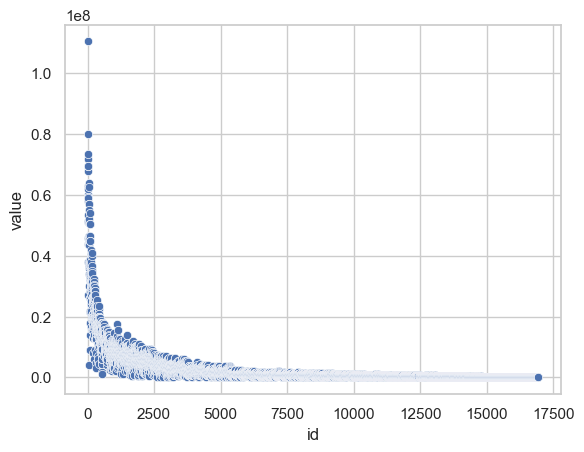

In [575]:
# train['value']의 이상치를 확인합니다.

sns.scatterplot(data=train, x=train.index, y='value')

In [576]:
# 이상치의 값의 정보를 확인합니다.

train[train['value'] > 100000000]

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
id,,,,,,,,,,
0,31,4,2021,3,0,5.0,94,94,4.0,110500000.0


In [577]:
# 얕은 복사를 통해 이상치를 제거해줍니다.

train = train[train['value'] < 100000000].copy()
train

,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
id,,,,,,,,,,
3,27,2,2020,1,1,4.0,91,93,1.0,72000000.0
7,31,4,2021,3,1,5.0,91,91,3.0,80000000.0
8,32,2,2020,0,1,4.0,91,91,3.0,51000000.0
9,25,2,2021,1,1,3.0,90,93,1.0,68000000.0
12,32,4,2019,0,1,3.0,90,90,2.0,44000000.0
...,...,...,...,...,...,...,...,...,...,...
16925,18,0,2019,2,1,1.0,48,63,3.0,60000.0
16936,19,2,2020,0,1,1.0,47,59,2.0,40000.0
16941,18,4,2021,0,1,1.0,47,64,2.0,50000.0


## 정규화

/var/folders/bc/60nf7pjs0rv35qdbssct76sc0000gn/T/ipykernel_985/3327115436.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train['value'], kde = True, color = 'c')


Text(0.5, 1.0, 'Distribution of value')

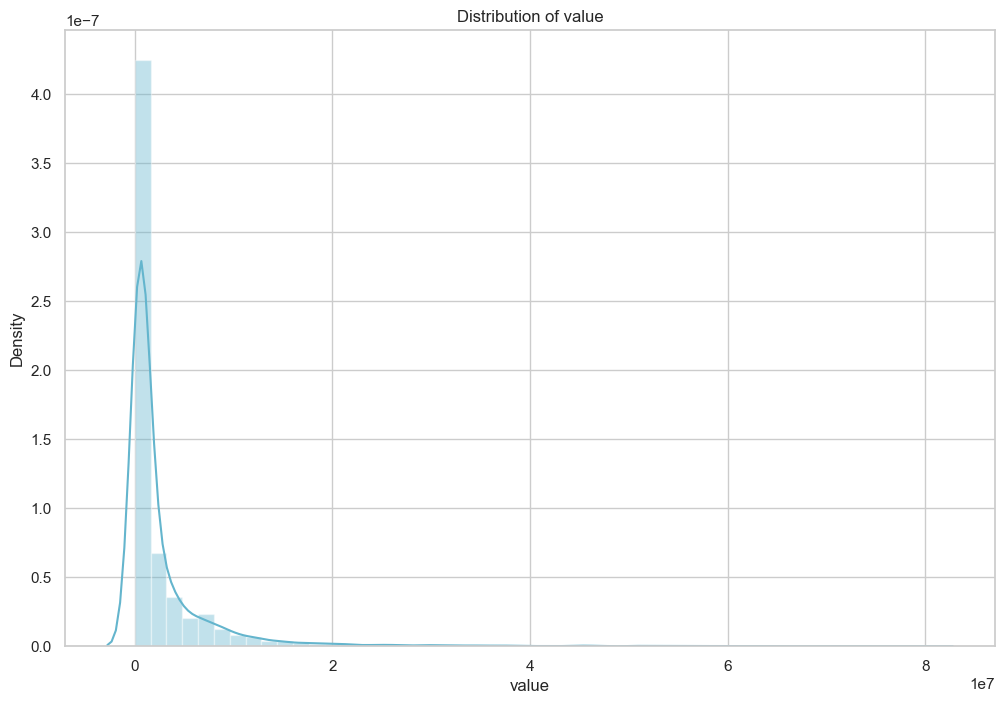

In [578]:
# value의 분포를 확인합니다.
# 이상치를 제거했음에도 불구하고, 좌측으로 치우쳐 있어 정규성이 낮습니다.

sns.set(style='whitegrid')
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.distplot(train['value'], kde = True, color = 'c')
plt.title('Distribution of value')

/var/folders/bc/60nf7pjs0rv35qdbssct76sc0000gn/T/ipykernel_985/298853902.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(np.log10(train['value']), kde=True, color='r')


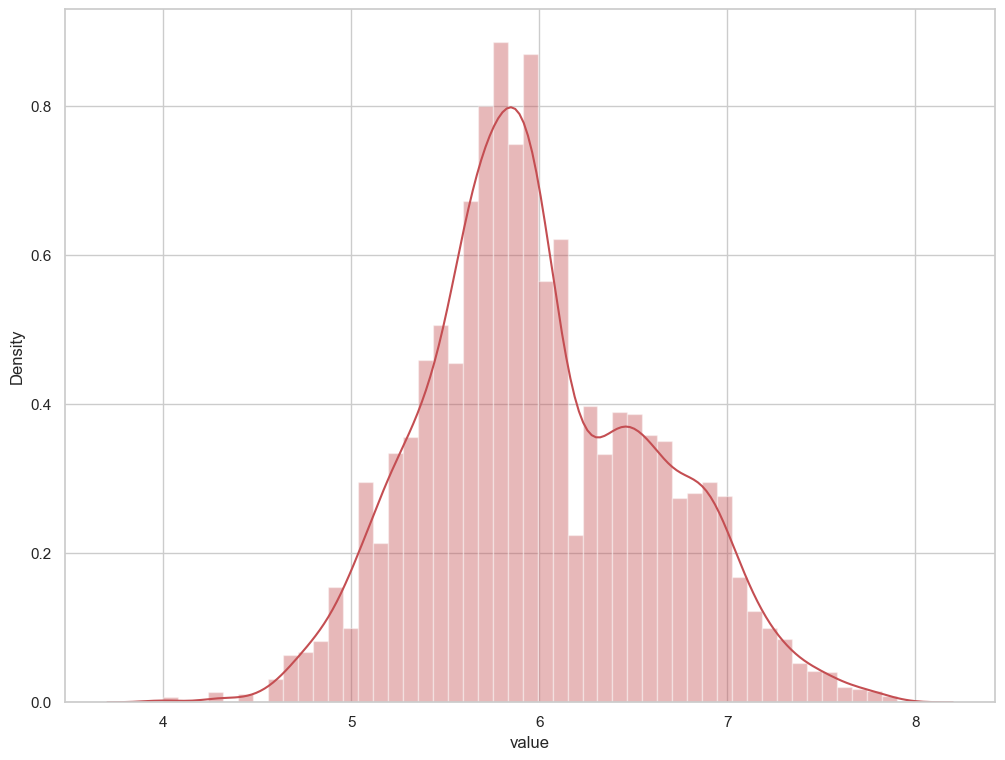

In [579]:
# 정규성을 높이기 위해 상용로그를 활용하여 그래프를 그립니다.

f, ax = plt.subplots(1, 1, figsize=(12, 9))
ax = sns.distplot(np.log10(train['value']), kde=True, color='r')

/var/folders/bc/60nf7pjs0rv35qdbssct76sc0000gn/T/ipykernel_985/3576680435.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.zeros_like(train.corr(),dtype=np.bool)


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'continent'),
  Text(2.5, 0, 'contract_until'),
  Text(3.5, 0, 'position'),
  Text(4.5, 0, 'prefer_foot'),
  Text(5.5, 0, 'reputation'),
  Text(6.5, 0, 'stat_overall'),
  Text(7.5, 0, 'stat_potential'),
  Text(8.5, 0, 'stat_skill_moves'),
  Text(9.5, 0, 'value')])

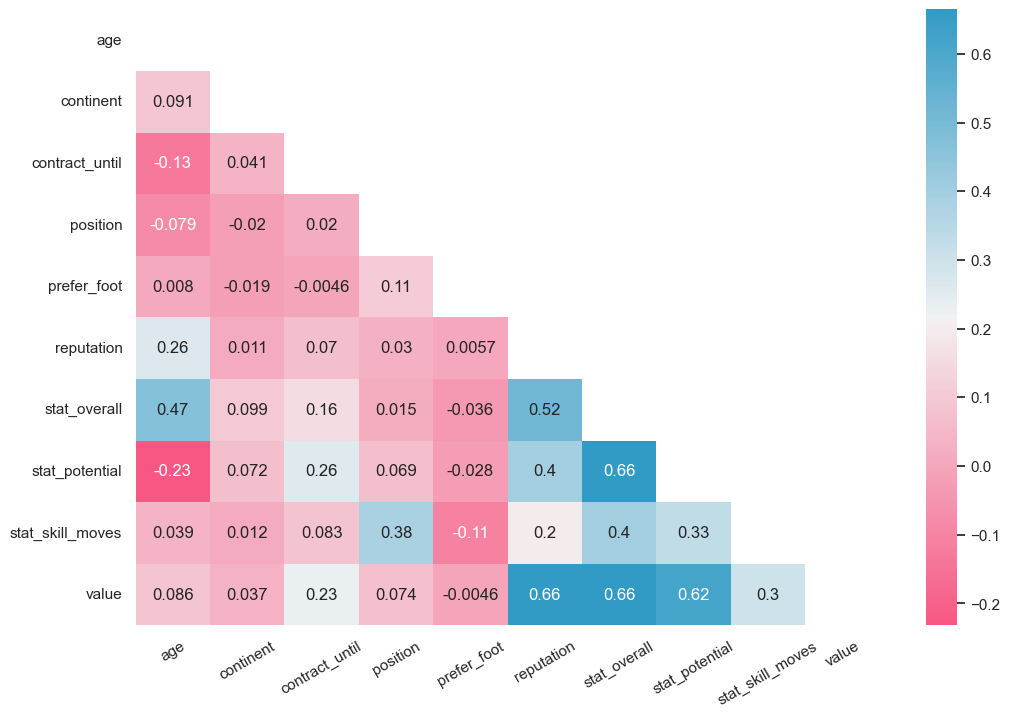

In [580]:
# 전체적인 상관관계를 heatmap으로 시각화합니다.
# 다음의 순서대로 value와의 상관관계가 보입니다.
# stat_overall > reputation > stat_potential > stat_skill_moves

mask=np.zeros_like(train.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, mask=mask, cmap=cmap)
plt.xticks(rotation = 30)

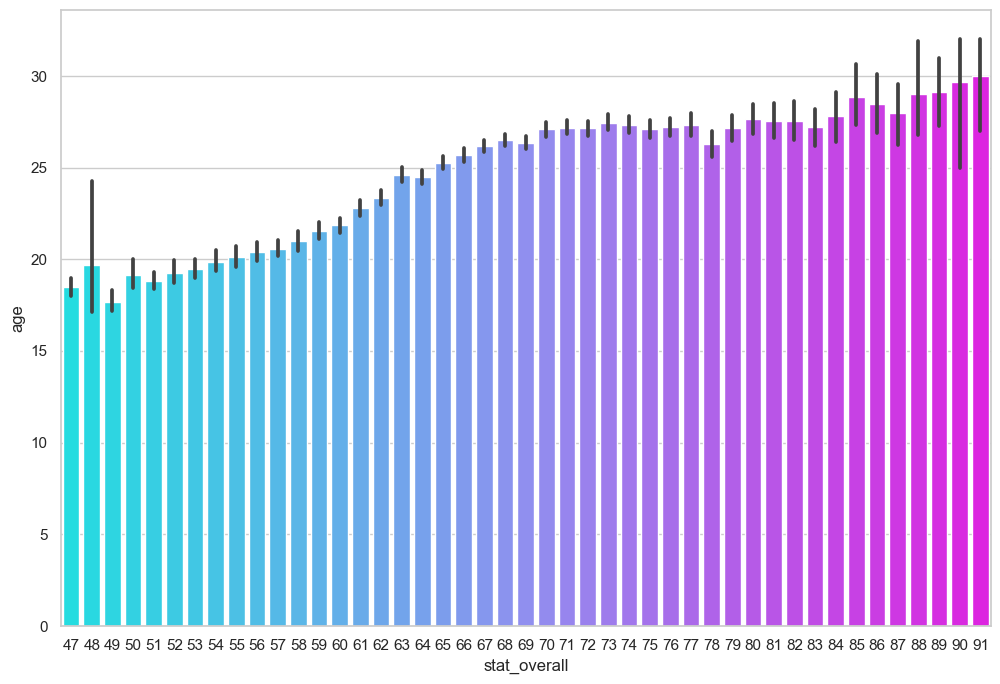

In [581]:
# reputation, stat_overall, stat_potential 외에 영향을 줄 수 있는 요소를 시각화 합니다.
# stat_overall - age의 분포를 시각화합니다.

f, plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='stat_overall', y='age', data=train, palette='cool')

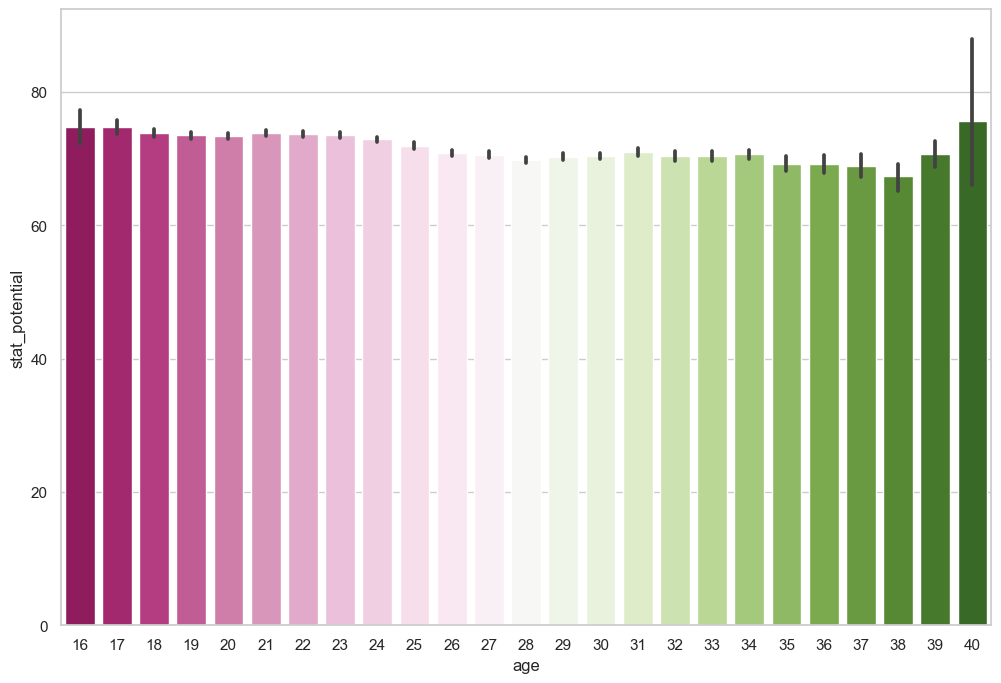

In [582]:
# 나이대 별 발전 가능성 평가는 평이하게 분포하고 있습니다.
# 잠재력에 있어서 연령대를 고려하기 보다 실력과 태도에 우선한다는 것을 알 수 있습니다.

f, plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='age', y='stat_potential', data=train, palette='PiYG')

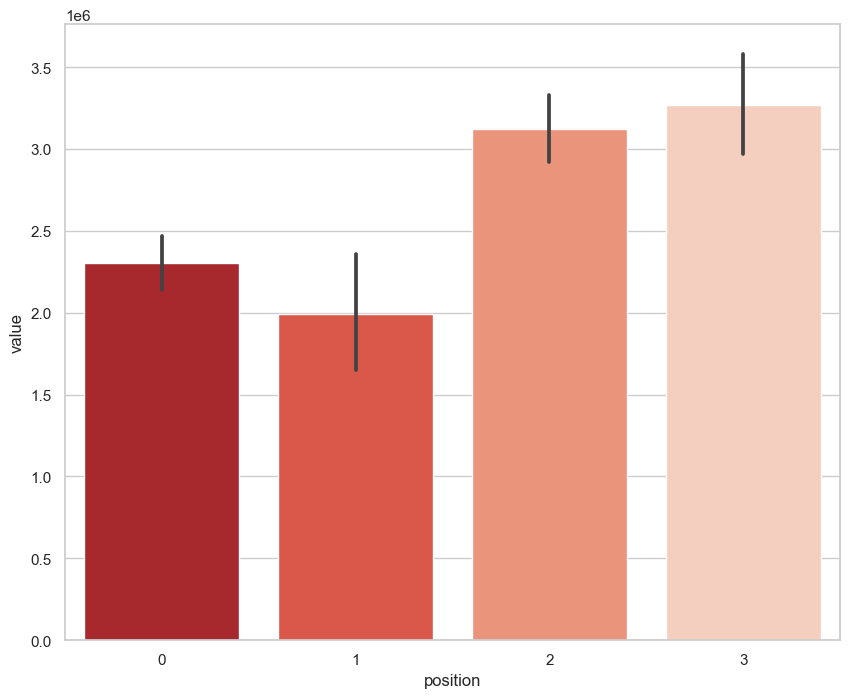

In [583]:
# position과 value의 관계 또한 알아봅니다.
# 3번 position에 Value값이 더 많이 확인됩니다.

f, ax = plt.subplots(1, 1, figsize=(10, 8))
ax = sns.barplot(x = 'position', y = 'value', data=train, palette='Reds_r')

In [584]:
# train으로 X, y 만들기

X = train.drop('value', axis='columns')
y = train['value']
X.shape, y.shape

((8931, 9), (8931,))

In [585]:
# train_test_split
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
  X, y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((7144, 9), (1787, 9), (7144,), (1787,))

In [586]:
X_test = test
X_test.shape

(3828, 9)

In [587]:
# 모델을 불러옵니다. 
# 데이터의 값이 다양하여 시각화를 고려해 GradientBoostingRegressor를 적용합니다.
# model_gbt
from sklearn.ensemble import GradientBoostingRegressor

model_gbt = GradientBoostingRegressor(random_state=42)

In [588]:
model_gbt.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [589]:
gbt_score = model_gbt.score(X_valid, y_valid)
gbt_score 

0.990845988722913

In [590]:
y_predict = model_gbt.predict(X_test)
y_predict[:5]

array([60232295.26421756, 82131963.7156814 , 74464936.06426784,
       74024915.1495524 , 65577134.75062916])

In [591]:
# submission
submission = pd.read_csv(f'submission.csv', index_col="id")

In [592]:
submission['value'] = y_predict

In [593]:
file_name = f'sumbission_{gbt_score:.5f}.csv'
file_name

'sumbission_0.99085.csv'

In [594]:
submission.to_csv(file_name)
pd.read_csv(file_name).head(5)

,id,value
0,1,6.023230e+07
1,2,8.213196e+07
2,4,7.446494e+07
3,5,7.402492e+07
4,6,6.557713e+07


In [595]:
# 랜덤포레스트 회귀모델을 적용하였습니다.

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
model

RandomForestRegressor(n_jobs=-1)

In [596]:
# 회귀모델을 데이터셋에 적용시킵니다.
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [597]:
# 기본 함수로 성능 점수를 출력합니다.

score = model.score(X_valid, y_valid)
score

0.9901132796489951

<AxesSubplot:xlabel='value'>

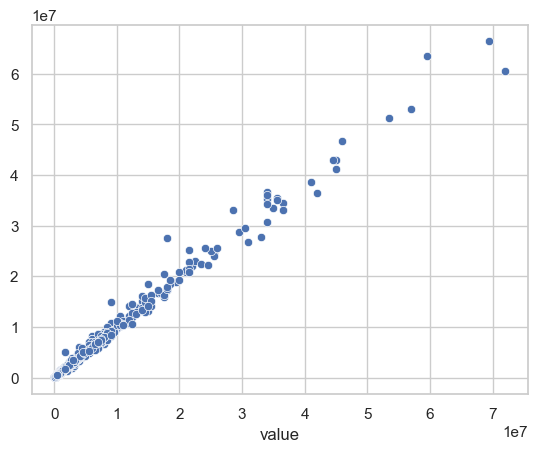

In [598]:
# 예측값의 산점도를 그려줍니다. 선형으로 나열된 수치를 확인할 수 있습니다.
# 예측값과 타깃값 사이의 약간의 상관관계를 확인할 수 있습니다.

sns.scatterplot(x=y_valid, y=model.predict(X_valid))

<AxesSubplot:>

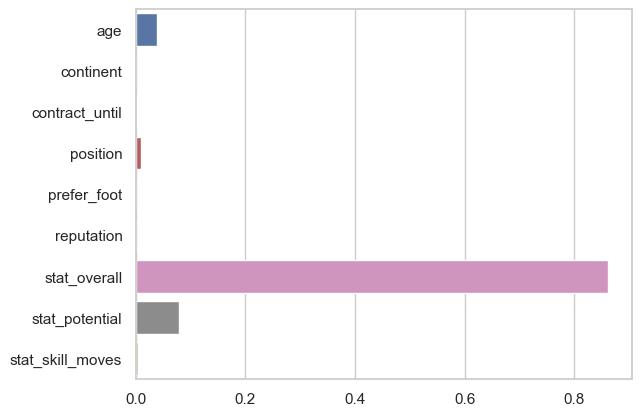

In [599]:
# 피처의 중요도를 시각화합니다.
# stat_overall이 중요한 요소라는 것을 확인할 수 있습니다.
sns.barplot(x=model.feature_importances_, y=model.feature_names_in_)

In [600]:
# 예측을 실시합니다.

y_predict_rf = model.predict(X_test)
y_predict_rf[:5]

array([55830000., 73425000., 65570000., 68210000., 61745000.])

## KFold로 Cross-Validation 해보기

In [601]:
# KFold 를 사용해서 분할을 나눕니다.
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf

KFold(n_splits=5, random_state=42, shuffle=True)

### Cross_val_predict

In [602]:
# cross_val_predict 로 예측 결과를 구합니다.
# y_valid_predict 에 결과를 담습니다.
from sklearn.model_selection import cross_val_predict
y_valid_predict = cross_val_predict(model, X_train, y_train, cv=kf, n_jobs=-1)
y_valid_predict

array([7495000.,  585750.,  657750., ...,  469000., 5477000.,  376550.])

In [603]:
submission['value'] = y_predict_rf

In [604]:
file_name_2 = f'sumbission_{score:.5f}.csv'
file_name_2

'sumbission_0.99011.csv'

In [605]:
submission.to_csv(file_name_2)
pd.read_csv(file_name_2).head(5)

,id,value
0,1,55830000.0
1,2,73425000.0
2,4,65570000.0
3,5,68210000.0
4,6,61745000.0
